#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [41]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [3]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

def return_lemma(token):
    return morph.parse(token)[0].normal_form

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [return_lemma(token) for token in tokens]
    return tokens

In [441]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [442]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [443]:
len(filtered_vocab)

11987

In [444]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [445]:
id2word = {i:word for word, i in word2id.items()}

In [446]:
sentences = []
for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

## SkipGram

In [447]:
# skip gram
X = []
y = []

window = 12
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window] 

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [448]:
from random import random
from bisect import bisect

def weighted_choice(values, weights):
    total = 0
    cum_weights = []
    for w in weights:
        total += w
        cum_weights.append(total)
    x = random() * total
    i = bisect(cum_weights, x)
    return values[i]

In [449]:
weighted_choice(list(probs_id.keys()), inverse_probability)

2910

In [450]:
# skip gram
def gen_batches_sg(sentences, probs_id, inverse_probability, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
#                     X_context.append(np.random.choice(list(probs_id.keys()), p=list(inverse_probability)))
                    X_context.append(weighted_choice(list(probs_id.keys()), inverse_probability))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [451]:
probs = dict()
summa = 0
for el in word2id.keys():
    summa += vocab[el]
for el in word2id.keys():
    probs[el] = (vocab[el] / summa)

In [452]:
probs_id = dict()
for el in id2word.keys():
    probs_id[el] = probs[id2word[el]]

In [453]:
inverse_probability = [(1-x) for x in probs_id.values()]
inverse_probability = [x/sum(inverse_probability) for x in inverse_probability]

In [454]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [455]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(gen_batches_sg(sentences[:10000], probs_id=probs_id, inverse_probability=inverse_probability, window=5),
          validation_data=gen_batches_sg(sentences[10000:], probs_id=probs_id, inverse_probability=inverse_probability, window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

In [350]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [457]:
embeddings_sg

array([[ 0.00733243, -0.04357791, -0.03040538, ...,  0.0008682 ,
        -0.00533449, -0.04183025],
       [ 0.0510933 , -0.16332394, -0.11392925, ...,  0.05141505,
         0.00851451, -0.24266575],
       [-0.06946175,  0.06787024, -0.10097951, ..., -0.01747768,
         0.00719332, -0.07784453],
       ...,
       [ 0.0326532 , -0.02552987, -0.00651176, ..., -0.01274529,
        -0.00746864, -0.00185075],
       [-0.12107421, -0.07121219, -0.10681707, ..., -0.03537206,
         0.02592787,  0.21696618],
       [-0.04179142,  0.01882444,  0.0110376 , ...,  0.02325856,
        -0.01633014,  0.00440263]], dtype=float32)

## CBOW

In [352]:
X = []
y = []

window = 6
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [356]:
def gen_batches_cbow(sentences, probs_id, inverse_probability, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
#                 inverse_probability = [(1-x) for x in probs_id.values()]
#                 inverse_probability = [x/sum(inverse_probability) for x in inverse_probability]
                X_target.append(np.random.choice(list(probs_id.keys()), p=list(inverse_probability)))
#                 X_context.append(weighted_choice(list(probs_id.keys()), inverse_probability))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [357]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [358]:
model.fit(gen_batches_cbow(sentences[:19000], probs_id=probs_id, inverse_probability=inverse_probability, window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  probs_id=probs_id, inverse_probability=inverse_probability, window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 3328s 666ms/step - loss: 0.3555 - accuracy: 0.8478 - val_loss: 0.2938 - val_accuracy: 0.8804
Epoch 2/2
5000/5000 [==============================] - 3298s 660ms/step - loss: 0.2663 - accuracy: 0.8910 - val_loss: 0.2631 - val_accuracy: 0.8938


In [359]:
embeddings_cbow = model.layers[2].get_weights()[0]

## Evaluation

In [360]:
most_similar('машина', embeddings_sg)

['машина',
 'эффект',
 'поверхность',
 'управляемый',
 'кузов',
 'плоскость',
 'достаточно',
 'отрицательный',
 'спереди',
 'крен']

In [361]:
most_similar('таджикистан', embeddings_sg)

['таджикистан',
 '1970',
 'обком',
 'узбекистан',
 'сержант',
 'тула',
 'горком',
 '«об',
 'чехословакия',
 'уругвай']

In [362]:
most_similar('цик', embeddings_sg)

['цик',
 '1778',
 '3:1',
 'рупрехт',
 '2,4',
 'ношение',
 'контроллер',
 'эмилий',
 'превращать',
 'виконт']

In [363]:
most_similar('машина', embeddings_cbow)

['машина',
 'автомобиль',
 'двигатель',
 'модификация',
 'самолёт',
 'патрон',
 'кузов',
 'грузовик',
 'мощность',
 'вагон']

In [364]:
most_similar('таджикистан', embeddings_cbow)

['таджикистан',
 'прогрессивно-консервативный',
 'суринам',
 'венесуэла',
 'федеративный',
 'герцеговина',
 'нигерия',
 'туркменистан',
 'шри-ланка',
 'коста-рика']

In [365]:
most_similar('цик', embeddings_cbow)

['цик',
 'совнарком',
 'снк',
 'президиум',
 'коркмас',
 'рк',
 'исполком',
 '21.02.97',
 'политбюро',
 'вцик']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

## Word2Vec

In [ ]:
texts = [preprocess(sent) for sent in wiki]

In [107]:
%%time
from gensim.models import Word2Vec

w2v = gensim.models.Word2Vec(texts, 
                             vector_size=150, 
                             min_count=50, 
                             window=8,
                             epochs=5,
                             sg=0,
                             negative=10)

CPU times: user 46.5 s, sys: 216 ms, total: 46.7 s
Wall time: 16.6 s


In [108]:
w2v.wv.similar_by_word('церковь')

[('храм', 0.8058937191963196),
 ('собор', 0.7716497182846069),
 ('монастырь', 0.7416670322418213),
 ('православный', 0.7362950444221497),
 ('часовня', 0.7262058854103088),
 ('святитель', 0.7181317210197449),
 ('прихожанин', 0.7146062850952148),
 ('святыня', 0.7139266133308411),
 ('приход', 0.7019685506820679),
 ('епархия', 0.6950180530548096)]

In [106]:
w2v.wv.similar_by_word('автомобиль')

[('двигатель', 0.8030075430870056),
 ('мотор', 0.7985329627990723),
 ('легковой', 0.7820788621902466),
 ('шасси', 0.7801100015640259),
 ('машина', 0.7775271534919739),
 ('honda', 0.7482985258102417),
 ('lotus', 0.7452974915504456),
 ('модель', 0.7427676916122437),
 ('кузов', 0.7424094080924988),
 ('болид', 0.7362204194068909)]

In [109]:
w2v.wv.similar_by_word('собака')

[('охотиться', 0.7038978934288025),
 ('кошка', 0.6966310143470764),
 ('собачий', 0.6752084493637085),
 ('рыба', 0.6735085844993591),
 ('птица', 0.6731878519058228),
 ('животное', 0.666873574256897),
 ('мясо', 0.6529771685600281),
 ('хищник', 0.6504086256027222),
 ('моллюск', 0.64482581615448),
 ('зверь', 0.6434037089347839)]

## FastText

In [112]:
%%time
ft = gensim.models.FastText(texts, min_n=5, max_n=20)

CPU times: user 3min 17s, sys: 2.73 s, total: 3min 19s
Wall time: 1min 14s


In [113]:
ft.wv.most_similar('церковь')

[('церковь»', 0.9967513680458069),
 ('«церковь', 0.9965009689331055),
 ('морковь', 0.9675905108451843),
 ('церква', 0.9621313810348511),
 ('церкви»', 0.8940010666847229),
 ('перковы', 0.8845993876457214),
 ('собор', 0.8685480356216431),
 ('«собор', 0.8669697642326355),
 ('«храм', 0.8664926290512085),
 ('храм', 0.8623743653297424)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [6]:
data = pd.read_csv('labeled.csv')

In [7]:
data['norm_text'] = data.comment.apply(preprocess)

In [8]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6309

In [9]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [10]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [11]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=150)
y = data.toxic.values

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

# W2V

In [381]:
weights = np.zeros((len(word2id), 150))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = w2v.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [382]:
inputs = tf.keras.layers.Input(shape=(150,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=150, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [383]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 1s 1ms/step - loss: 0.6274 - accuracy: 0.6626 - val_loss: 0.6096 - val_accuracy: 0.6505
Epoch 2/30
428/428 [==============================] - 0s 967us/step - loss: 0.5943 - accuracy: 0.6658 - val_loss: 0.5900 - val_accuracy: 0.6491
Epoch 3/30
428/428 [==============================] - 0s 954us/step - loss: 0.5766 - accuracy: 0.6671 - val_loss: 0.5756 - val_accuracy: 0.6505
Epoch 4/30
428/428 [==============================] - 0s 1ms/step - loss: 0.5638 - accuracy: 0.6712 - val_loss: 0.5642 - val_accuracy: 0.6602
Epoch 5/30
428/428 [==============================] - 0s 954us/step - loss: 0.5538 - accuracy: 0.6796 - val_loss: 0.5549 - val_accuracy: 0.6741
Epoch 6/30
428/428 [==============================] - 0s 1ms/step - loss: 0.5458 - accuracy: 0.6898 - val_loss: 0.5470 - val_accuracy: 0.6921
Epoch 7/30
428/428 [==============================] - 0s 989us/step - loss: 0.5391 - accuracy: 0.6993 - val_loss: 0.5406 - val_accuracy: 0.697

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


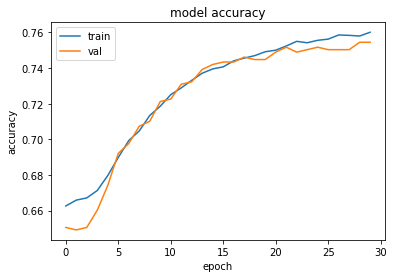

In [384]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# FT

In [395]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = ft.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [399]:
inputs = tf.keras.layers.Input(shape=(150,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [400]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 1s 1ms/step - loss: 0.6244 - accuracy: 0.6517 - val_loss: 0.6122 - val_accuracy: 0.6477
Epoch 2/30
428/428 [==============================] - 0s 1ms/step - loss: 0.5968 - accuracy: 0.6685 - val_loss: 0.6012 - val_accuracy: 0.6546
Epoch 3/30
428/428 [==============================] - 0s 945us/step - loss: 0.5866 - accuracy: 0.6731 - val_loss: 0.5951 - val_accuracy: 0.6560
Epoch 4/30
428/428 [==============================] - 0s 969us/step - loss: 0.5804 - accuracy: 0.6789 - val_loss: 0.5892 - val_accuracy: 0.6657
Epoch 5/30
428/428 [==============================] - 0s 960us/step - loss: 0.5759 - accuracy: 0.6812 - val_loss: 0.5853 - val_accuracy: 0.6657
Epoch 6/30
428/428 [==============================] - 0s 945us/step - loss: 0.5726 - accuracy: 0.6828 - val_loss: 0.5814 - val_accuracy: 0.6699
Epoch 7/30
428/428 [==============================] - 1s 1ms/step - loss: 0.5700 - accuracy: 0.6854 - val_loss: 0.5788 - val_accuracy: 0.674

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


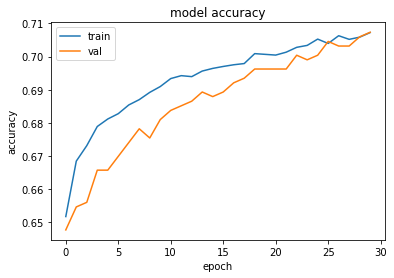

In [401]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# CBOW

# SG

# RusVectores

In [30]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [32]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [33]:
from pymystem3 import Mystem
m = Mystem()

In [34]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [36]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('180/model.bin', binary=True)

In [37]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = model[normalize_mystem(word)[0]]
    except KeyError:
        continue
        weights[i] = model.wv['опрагпллирао']
    except IndexError:
        continue

In [38]:
inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Train on 13691 samples, validate on 721 samples
Epoch 1/30
13691/13691 [==============================] - 7s 507us/sample - loss: 0.6098 - accuracy: 0.6661 - val_loss: 0.5800 - val_accuracy: 0.6602
Epoch 2/30
13691/13691 [==============================] - 7s 489us/sample - loss: 0.5561 - accuracy: 0.6784 - val_loss: 0.5542 - val_accuracy: 0.6755
Epoch 3/30
13691/13691 [==============================] - 7s 507us/sample - loss: 0.5331 - accuracy: 0.6997 - val_loss: 0.5368 - val_accuracy: 0.6976
Epoch 4/30
13691/13691 [==============================] - 7s 546us/sample - loss: 0.5169 - accuracy: 0.7248 - val_loss: 0.5236 - val_accuracy: 0.7282
Epoch 5/30
13691/13691 [==============================] - 6s 405us/sample - loss: 0.5047 - accuracy: 0.7462 - val_loss: 0.5132 - val_accuracy: 0.7531
Epoch 6/30
13691/13691 [==============================] - 6s 462us/sample - loss: 0.4951 - accuracy: 0.7636 - val_loss: 0.5051 - val_accuracy: 0.7642
Epoch 7/30
13691/13691 [============================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


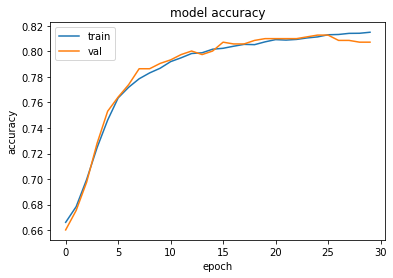

In [40]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Модель из RusVectores справляется лучше